In [19]:
# This example demonstrates the behaviour of the accuracy of the nearest neighbor queries of Locality 
# Sensitive Hashing Forest as the number of candidates and the number of estimators (trees) vary.

# http://scikit-learn.org/stable/auto_examples/neighbors/plot_approximate_nearest_neighbors_hyperparameters.html

%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline. 
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import LSHForest
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import time


# Initialize size of the database, iterations and required neighbors.
n_samples = 10000
n_features = 100
n_queries = 30
rng = np.random.RandomState(42)

# Generate sample data
X, _ = make_blobs(n_samples=n_samples + n_queries,
                  n_features=n_features, centers=10,
                  random_state=0)
X_index = X[:n_samples]
X_query = X[n_samples:]

In [20]:
# Get exact neighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute',
                        metric='cosine').fit(X_index)
neighbors_exact = nbrs.kneighbors(X_query, return_distance=False)

In [21]:
# Set `n_candidate` values
n_candidates_values = np.linspace(10, 500, 5).astype(np.int)
n_estimators_for_candidate_value = [1, 5, 10]
n_iter = 10
stds_accuracies = np.zeros((len(n_estimators_for_candidate_value),
                            n_candidates_values.shape[0]),
                           dtype=float)
accuracies_c = np.zeros((len(n_estimators_for_candidate_value),
                         n_candidates_values.shape[0]), dtype=float)

# LSH Forest is a stochastic index: perform several iteration to estimate
# expected accuracy and standard deviation displayed as error bars in
# the plots
for j, value in enumerate(n_estimators_for_candidate_value):
    for i, n_candidates in enumerate(n_candidates_values):
        accuracy_c = []
        for seed in range(n_iter):
            lshf = LSHForest(n_estimators=value,
                             n_candidates=n_candidates, n_neighbors=1,
                             random_state=seed)
            # Build the LSH Forest index
            lshf.fit(X_index)
            # Get neighbors
            neighbors_approx = lshf.kneighbors(X_query,
                                               return_distance=False)
            accuracy_c.append(np.sum(np.equal(neighbors_approx,
                                              neighbors_exact)) /
                              n_queries)

        stds_accuracies[j, i] = np.std(accuracy_c)
        accuracies_c[j, i] = np.mean(accuracy_c)

# Set `n_estimators` values
n_estimators_values = [1, 5, 10, 20, 30, 40, 50]
accuracies_trees = np.zeros(len(n_estimators_values), dtype=float)

# Calculate average accuracy for each value of `n_estimators`
for i, n_estimators in enumerate(n_estimators_values):
    lshf = LSHForest(n_estimators=n_estimators, n_neighbors=1)
    # Build the LSH Forest index
    lshf.fit(X_index)
    # Get neighbors
    neighbors_approx = lshf.kneighbors(X_query, return_distance=False)
    accuracies_trees[i] = np.sum(np.equal(neighbors_approx,
                                          neighbors_exact))/n_queries

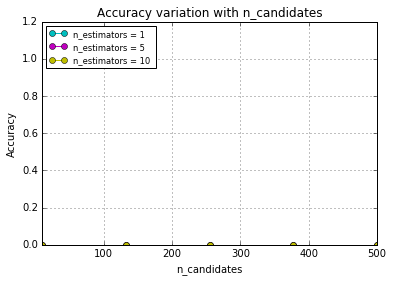

In [22]:
# Plot the accuracy variation with `n_candidates`
plt.figure()
colors = ['c', 'm', 'y']
for i, n_estimators in enumerate(n_estimators_for_candidate_value):
    label = 'n_estimators = %d ' % n_estimators
    plt.plot(n_candidates_values, accuracies_c[i, :],
             'o-', c=colors[i], label=label)
    plt.errorbar(n_candidates_values, accuracies_c[i, :],
                 stds_accuracies[i, :], c=colors[i])

plt.legend(loc='upper left', fontsize='small')
plt.ylim([0, 1.2])
plt.xlim(min(n_candidates_values), max(n_candidates_values))
plt.ylabel("Accuracy")
plt.xlabel("n_candidates")
plt.grid(which='both')
plt.title("Accuracy variation with n_candidates")

plt.show()

In [23]:
# In the first plot, accuracy is measured with the number of candidates. 
# Here, the term “number of candidates” refers to maximum bound for the number of distinct points 
# retrieved from each tree to calculate the distances. 
# Nearest neighbors are selected from this pool of candidates. 
# Number of estimators is maintained at three fixed levels (1, 5, 10).

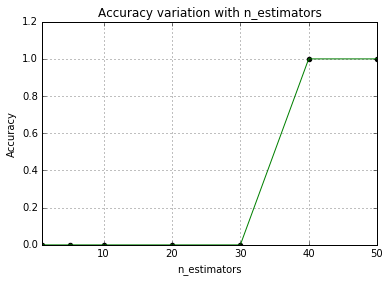

In [24]:
# Plot the accuracy variation with `n_estimators`
plt.figure()
plt.scatter(n_estimators_values, accuracies_trees, c='k')
plt.plot(n_estimators_values, accuracies_trees, c='g')
plt.ylim([0, 1.2])
plt.xlim(min(n_estimators_values), max(n_estimators_values))
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.grid(which='both')
plt.title("Accuracy variation with n_estimators")

plt.show()

In [25]:
# In the second plot, the number of candidates is fixed at 50. 
# Number of trees is varied and the accuracy is plotted against those values. 

In [26]:
# Then, we examine the scalability profile of approximate 10-neighbors queries using the LSHForest with n_estimators=20 and n_candidates=200 
# when varying the number of samples in the dataset.

# Parameters of the study
n_samples_min = int(1e3)
n_samples_max = int(1e5)
n_features = 100
n_centers = 100
n_queries = 100
n_steps = 6
n_iter = 5

# Initialize the range of `n_samples`
n_samples_values = np.logspace(np.log10(n_samples_min),
                               np.log10(n_samples_max),
                               n_steps).astype(np.int)

# Generate some structured data
rng = np.random.RandomState(42)
all_data, _ = make_blobs(n_samples=n_samples_max + n_queries,
                         n_features=n_features, centers=n_centers, shuffle=True,
                         random_state=0)
queries = all_data[:n_queries]
index_data = all_data[n_queries:]

# Metrics to collect for the plots
average_times_exact = []
average_times_approx = []
std_times_approx = []
accuracies = []
std_accuracies = []
average_speedups = []
std_speedups = []

In [27]:
# Calculate the average query time
for n_samples in n_samples_values:
    X = index_data[:n_samples]
    # Initialize LSHForest for queries of a single neighbor
    lshf = LSHForest(n_estimators=20, n_candidates=200,
                     n_neighbors=10).fit(X)
    nbrs = NearestNeighbors(algorithm='brute', metric='cosine',
                            n_neighbors=10).fit(X)
    time_approx = []
    time_exact = []
    accuracy = []

    for i in range(n_iter):
        # pick one query at random to study query time variability in LSHForest
        query = queries[[rng.randint(0, n_queries)]]

        t0 = time.time()
        exact_neighbors = nbrs.kneighbors(query, return_distance=False)
        time_exact.append(time.time() - t0)

        t0 = time.time()
        approx_neighbors = lshf.kneighbors(query, return_distance=False)
        time_approx.append(time.time() - t0)

        accuracy.append(np.in1d(approx_neighbors, exact_neighbors).mean())

    average_time_exact = np.mean(time_exact)
    average_time_approx = np.mean(time_approx)
    speedup = np.array(time_exact) / np.array(time_approx)
    average_speedup = np.mean(speedup)
    mean_accuracy = np.mean(accuracy)
    std_accuracy = np.std(accuracy)
    print("Index size: %d, exact: %0.3fs, LSHF: %0.3fs, speedup: %0.1f, "
          "accuracy: %0.2f +/-%0.2f" %
          (n_samples, average_time_exact, average_time_approx, average_speedup,
           mean_accuracy, std_accuracy))

    accuracies.append(mean_accuracy)
    std_accuracies.append(std_accuracy)
    average_times_exact.append(average_time_exact)
    average_times_approx.append(average_time_approx)
    std_times_approx.append(np.std(time_approx))
    average_speedups.append(average_speedup)
    std_speedups.append(np.std(speedup))

Index size: 1000, exact: 0.001s, LSHF: 0.007s, speedup: 0.1, accuracy: 1.00 +/-0.00
Index size: 2511, exact: 0.003s, LSHF: 0.009s, speedup: 0.3, accuracy: 1.00 +/-0.00
Index size: 6309, exact: 0.008s, LSHF: 0.015s, speedup: 0.5, accuracy: 1.00 +/-0.00
Index size: 15848, exact: 0.021s, LSHF: 0.020s, speedup: 1.1, accuracy: 0.98 +/-0.04
Index size: 39810, exact: 0.048s, LSHF: 0.022s, speedup: 2.3, accuracy: 1.00 +/-0.00
Index size: 100000, exact: 0.111s, LSHF: 0.031s, speedup: 3.8, accuracy: 1.00 +/-0.00


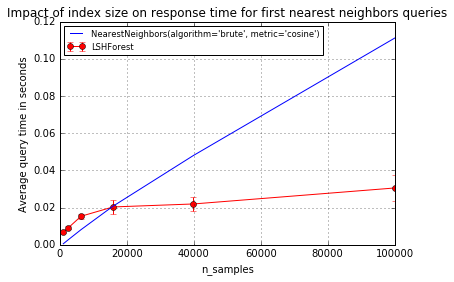

In [28]:
# Plot average query time against n_samples
plt.figure()
plt.errorbar(n_samples_values, average_times_approx, yerr=std_times_approx,
             fmt='o-', c='r', label='LSHForest')
plt.plot(n_samples_values, average_times_exact, c='b',
         label="NearestNeighbors(algorithm='brute', metric='cosine')")
plt.legend(loc='upper left', fontsize='small')
plt.ylim(0, None)
plt.ylabel("Average query time in seconds")
plt.xlabel("n_samples")
plt.grid(which='both')
plt.title("Impact of index size on response time for first "
          "nearest neighbors queries")
plt.show()

In [ ]:
# This plot demonstrates the relationship between query time and index size of LSHForest. 
# Query time is compared with the brute force method in exact nearest neighbor search for the same index sizes. 
# The brute force queries have a very predictable linear scalability with the index (full scan). 
# LSHForest index have sub-linear scalability profile but can be slower for small datasets.

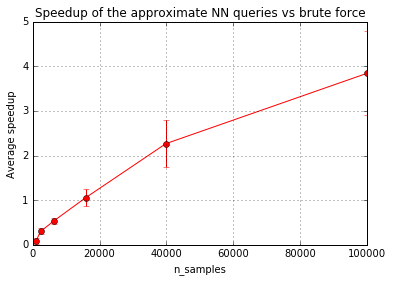

In [29]:
# Plot average query speedup versus index size
plt.figure()
plt.errorbar(n_samples_values, average_speedups, yerr=std_speedups,
             fmt='o-', c='r')
plt.ylim(0, None)
plt.ylabel("Average speedup")
plt.xlabel("n_samples")
plt.grid(which='both')
plt.title("Speedup of the approximate NN queries vs brute force")
plt.show()

In [ ]:
# The second plot shows the speedup when using approximate queries vs brute force exact queries. 
# The speedup tends to increase with the dataset size but should reach a plateau typically 
# when doing queries on datasets with millions of samples and a few hundreds of dimensions. 
# Higher dimensional datasets tends to benefit more from LSHForest indexing.

# The break even point (speedup = 1) depends on the dimensionality and structure of the indexed data 
# and the parameters of the LSHForest index.

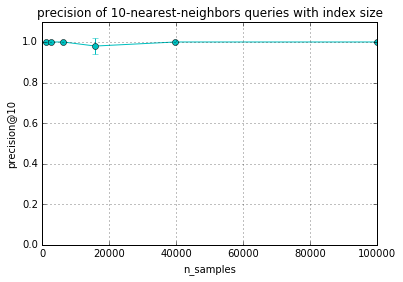

In [30]:
# Plot average precision versus index size
plt.figure()
plt.errorbar(n_samples_values, accuracies, std_accuracies, fmt='o-', c='c')
plt.ylim(0, 1.1)
plt.ylabel("precision@10")
plt.xlabel("n_samples")
plt.grid(which='both')
plt.title("precision of 10-nearest-neighbors queries with index size")
plt.show()

In [ ]:
# The precision of approximate queries should decrease slowly with the dataset size. 
# The speed of the decrease depends mostly on the LSHForest parameters and the dimensionality of the data.